<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#построил--недельную" data-toc-modified-id="построил--недельную-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>построил  недельную</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель проекта** - подобрать наилучшую модель для предсказаний заказов такси.

**Задачи проекта** - ресемплировать, проанализировать данные и обучить на них 2 модели.

## Подготовка

In [1]:
import pandas as pd 

from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from lightgbm import LGBMRegressor 
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

OSError: dlopen(/Users/macbook/anaconda3/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/macbook/anaconda3/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [ ]:
#подключаю датасет
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('C:/Users/Ivan_v/taxi.csv')

In [ ]:
print(f'Краткая информация')
print(f'Строки {data.shape[0]}')
print(f'Столбцы {data.shape[1]}')

Краткая информация
Строки 26496
Столбцы 2


In [ ]:
# вывожу информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
# смотрю лучайные 10 записей из этого датасета.
data.sample(10) 

,datetime,num_orders
6251,2018-04-13 09:50:00,9
15904,2018-06-19 10:40:00,11
19398,2018-07-13 17:00:00,19
13932,2018-06-05 18:00:00,10
9156,2018-05-03 14:00:00,4
24263,2018-08-16 11:50:00,20
11465,2018-05-19 14:50:00,11
17709,2018-07-01 23:30:00,26
4854,2018-04-03 17:00:00,9
5065,2018-04-05 04:10:00,13


In [ ]:
#ищю пропуски
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Провреду проверку на монотонность

In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
data = data.set_index('datetime')
data = data.sort_index()
data.index.is_monotonic

True

Сделаю ресемплинг датасета по часам.

In [ ]:
# ресемплинг
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [ ]:
# вывожу информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод**
- Загрузил и обработал датасет о заказах такси. Данные за 6 месяцев 2018 года. 
- Пропуски не обнаружил- ничего не надо модернизировать
- Сделал ресемплирование данных по 1 часу. Это должно помочь уменьшить объем данных и изменить разрешение временных рядов для анализа и прогнозирования.

## Анализ

<AxesSubplot:title={'center':'Количество заказов такси в зависимости от времени'}, xlabel='Дата-время заказа такси', ylabel='Кол-во заказов'>

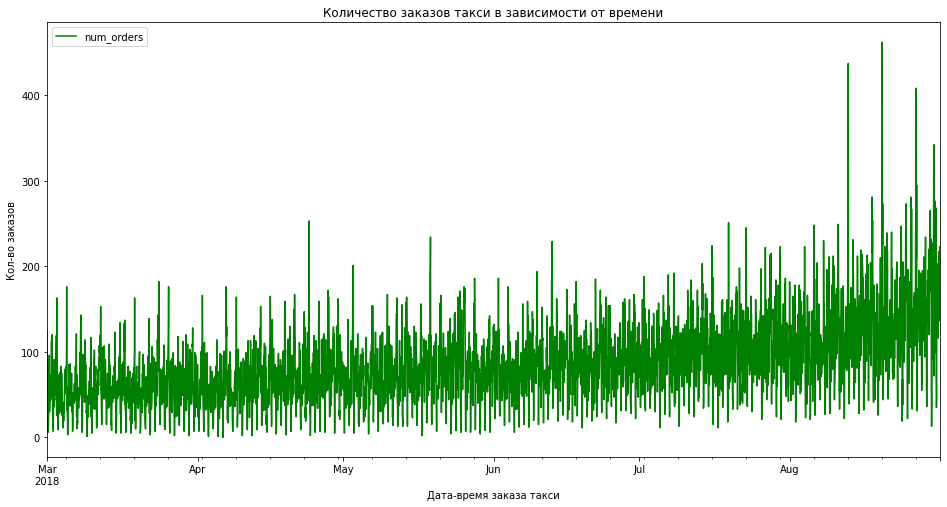

In [ ]:
data.plot(figsize=(16,8), title='Количество заказов такси в зависимости от времени', xlabel='Дата-время заказа такси', ylabel='Кол-во заказов', color='green')

In [ ]:
data.mean()# посмотрю среднее кол-во заказов

num_orders    84.422781
dtype: float64

в среднем 84 заказа

In [ ]:
print('Минимальные число и время в данных:', data.index.min())

Минимальные число и время в данных: 2018-03-01 00:00:00


In [ ]:
print('Максимальные число и время в данных:', data.index.max())

Максимальные число и время в данных: 2018-08-31 23:00:00


Проанализируем наличие тренда, сезонности и остатков

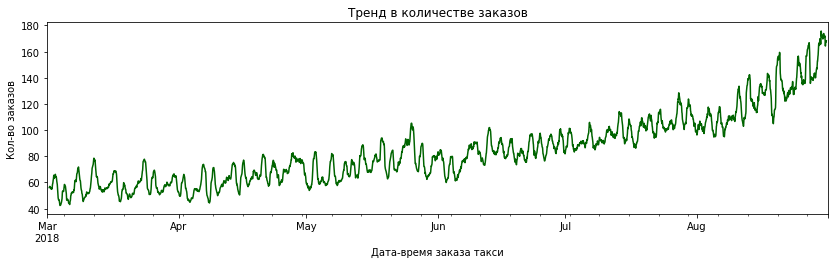

In [ ]:
#Посмотрю тренд в количестве заказов
decomposed = seasonal_decompose(data)
plt.figure(figsize=(14, 12))
decomposed.trend.plot(ax=plt.gca(),color='darkgreen')  
plt.title('Тренд в количестве заказов')
plt.xlabel('Дата-время заказа такси')
plt.ylabel('Кол-во заказов')

plt.show()

Построил тренд в заказах такси. Видно, что общий тренд показывает увеличение числа заказов 

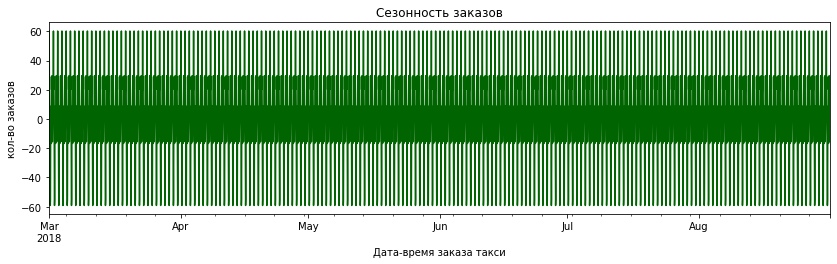

In [ ]:
#Посмотрю Сезонность заказов
decomposed = seasonal_decompose(data)
plt.figure(figsize=(14, 12))
decomposed.seasonal.plot(ax=plt.gca(),color='darkgreen')  
plt.title('Сезонность заказов')
plt.xlabel('Дата-время заказа такси')
plt.ylabel('кол-во заказов')


plt.show()

Из графика видно- сезонность имеет циклический характер и повторяется каждый месяц. 

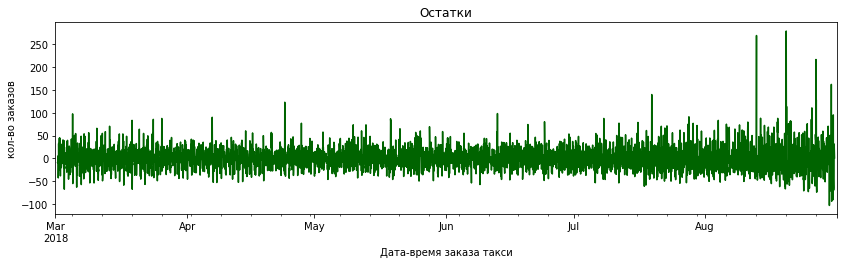

In [ ]:
#строю график остатков
decomposed = seasonal_decompose(data)
plt.figure(figsize=(14, 12))
decomposed.resid.plot(ax=plt.gca(), color='darkgreen') 
plt.title('Остатки')
plt.xlabel('Дата-время заказа такси')
plt.ylabel('кол-во заказов')

plt.show()

График показывает остатки временного ряда, то есть разницу между фактическими значениями ряда и которые предсказывает модель. Если остатки распределены случайным образом и не имеют явной структуры, то это говорит о том, что модель хорошо описывает данные. В данном случае, график остатков показывает, что модель описывает данные достаточно хорошо, так как остатки не имеют явных трендов, сезонности или других закономерностей.

В целом можно заключить, что заказов становится больше-виден восходящий тренд. 
Рассмотрю сезонность более укрупненно-возьму данные за 14 дней.

<AxesSubplot:title={'center':'Cезонность(по дням)'}, xlabel='datetime'>

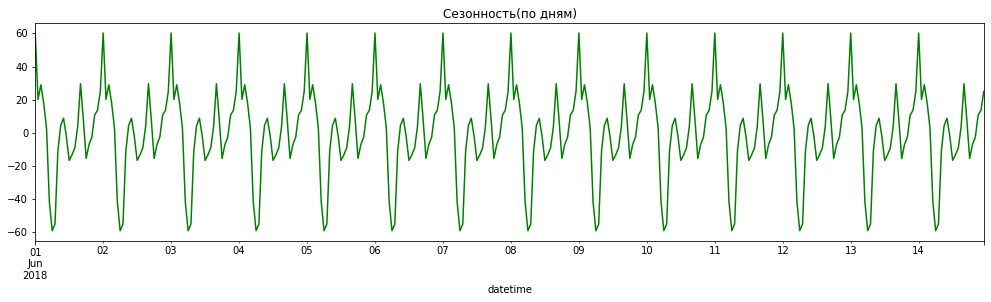

In [ ]:
#смотрю сезонность за 2 недели
plt.figure(figsize=(17,4))
plt.title('Cезонность(по дням)')
decomposed.seasonal['2018-06-01':'2018-06-14'].plot(ax=plt.gca(), color='green')

Есть сезонность по дням. Посмотрим отдельно пару дней.

#### Построил  недельную сезонность количества заказов такси за период с 1 по 14 июня 2018 года.

Укруплю анализ -посмотрю сезонность в течение дня

<AxesSubplot:title={'center':'Дневная сезонность(часы)'}, xlabel='datetime'>

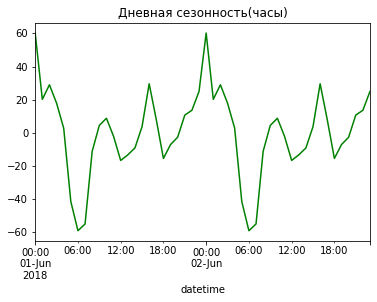

In [ ]:
import matplotlib.ticker as ticker


plt.title('Дневная сезонность(часы)')
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca(), color='green')


**Вывод**
- По тренду можно сказать что кол-во  заказа такси от марта к августу растет- сезонность.
- Есть суточная сезонность- Меньше всего заказов в 6 утра,три пиковых всплеска заказов: в 9-10 утра, после обеда и в 00. Выделяется пиковый спрос в вечернее время (начинает расти с 18:00  достигает пика в  22:00), затем, ночью, спрос падает и достигает минимума в районе 6 часов утра.







## Обучение

Сгенерируем нужные признаки на основе имеющихся данных -добавим  — месяц, день, день недели,время, скользящее среднее и лаги. Максимальный лаг возьмем равным неделе, а скользящее среднее будем считать в интервале 24 часа.

Строю скользящее среднее с недельной разбивкой

In [ ]:
data['rolling_mean'] = data.rolling(24*7).mean()


In [ ]:
#создаю признаки для обучения модели
def make_features(data, max_lag, size_of_rolling_mean):
    data_features = data.copy()
    data_features = data_features.drop(['rolling_mean'], axis=1)
    #data_features['year'] = data_features.index.year
    data_features['month'] = data_features.index.month
    data_features['day'] = data_features.index.day
    data_features['weekday'] = data_features.index.dayofweek
    data_features['hour'] = data_features.index.hour
    
    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data_features['num_orders'].shift(lag)

    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(size_of_rolling_mean).mean()
    return data_features

In [ ]:
data_features = make_features(data, 2, 24)
data_features

,num_orders,month,day,weekday,hour,lag_1,lag_2,r_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,NaN
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,168.041667


In [ ]:
#Разобью данные на тестовую и обучающую выборки. Выборку разбиваю на обучающую и тестовую в соотношении 90% к 10%.
train, test = train_test_split(data_features, shuffle=False, test_size=0.1)
train = train.dropna() # Удаляю пропуски
test = test.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [ ]:
# Выделяю в датасетах фичи и целевой признак
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

**Линейная регрессия**

Обучу модель линейной регрессии. Для кросс-валидации  использую метод time series split, специальный генератор разбиений для временных рядов.

In [ ]:
lin_model = LinearRegression()
lin_params = {}

lm_random= RandomizedSearchCV(lin_model, 
                           lin_params, 
                            scoring='neg_root_mean_squared_error', 
                            random_state=1988, 
                            cv=TimeSeriesSplit(n_splits=8))

lm_random.fit(features_train, target_train)
print('RMSE модели:', (rmse_lm_random := abs(lm_random.best_score_)))

RMSE модели: 31.18628382178396


Получил значение          метрики RMSE на линейной регрессии.

**Решающее дерево**

Обучаю модель дерева. ищу оптимальные значения с помощью randomized search.

In [ ]:
tree = DecisionTreeRegressor(random_state=1988)
tree_parametrs = {'max_depth': range(2, 100, 10),
              'min_samples_split': range(2, 10, 2)}

tree_choose = RandomizedSearchCV(tree, 
                            tree_parametrs, 
                            scoring='neg_root_mean_squared_error', 
                            random_state=1988, 
                            cv=TimeSeriesSplit(n_splits=8))

tree_choose.fit(features_train, target_train)
print('RMSE решающего дерева:', (rmse_tree_choose := abs(tree_choose.best_score_)))

RMSE решающего дерева: 28.834619666966653


**RandomForest**

In [ ]:
rf = RandomForestRegressor(random_state=1988)

rf_parametrs = {'n_estimators': range(50, 200, 20),
                'max_depth': range(2, 20, 2),
                'max_features': [None, 'sqrt', 'log2']}

rf_choose = RandomizedSearchCV(rf, 
                               rf_parametrs, 
                               scoring='neg_root_mean_squared_error', 
                               random_state=1988, 
                               cv=TimeSeriesSplit(n_splits=8))

rf_choose.fit(features_train, target_train)
print('RMSE случайного леса:', (rmse_rf_choose := abs(rf_choose.best_score_)))

RMSE случайного леса: 24.57175380987068


**CatBoostRegressor**

In [ ]:
catm = CatBoostRegressor(random_state=1988)

catm_parametrs = {'n_estimators': range(25, 100, 10),
'max_depth': [10, 15, 25]}

catm_choose = RandomizedSearchCV(catm,
catm_parametrs,
scoring='neg_root_mean_squared_error',
random_state=1988,
cv=TimeSeriesSplit(n_splits=8))

catm_choose.fit(features_train, target_train, verbose=False)

print('RMSE модели CatBoost:', (rmse_catm_choose := abs(catm_choose.best_score_)))

RMSE модели CatBoost: 25.900978380790477


**Вывод**

Обучил несколько моделей - LinearRegression, LightGBMRegressor,Решаюшее дерево, случайный лес . Лучший результат у 'случайного леса'. Далее тестирую лучшую модель на тестовой выборке.

In [ ]:
from IPython.display import display

final_metrics = pd.DataFrame(
    data = [rmse_lm_random, rmse_tree_choose, rmse_catm_choose, rmse_rf_choose],
    index = ['Линейная регрессия', 'Дерево', 'CatBoost', 'RandomForest'],
    columns = ['RMSE']
)
final_metrics = final_metrics.sort_values(by='RMSE', ascending=False)

display(final_metrics)

,RMSE
Линейная регрессия,31.186284
Дерево,28.834620
catm_choose,25.900978
случ лес,24.571754


## Тестирование

In [ ]:
model = RandomForestRegressor(random_state=1988)
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
RMSE_RF = mean_squared_error(target_test, pred_test )**0.5

print('RMSE для случайного леса на тестовой выборке = ', RMSE_RF)

RMSE для случайного леса на тестовой выборке =  47.24496933644692


Условие задачи 'Значение метрики RMSE на тестовой выборке должно быть не больше 48' выполнено. Визуализируем предсказанные и целевые значения.

In [ ]:
pred_test = pd.DataFrame(data = pred_test, index = target_test.index)

In [ ]:
pred_test  = pred_test .rename(columns={0:'num_orders'})

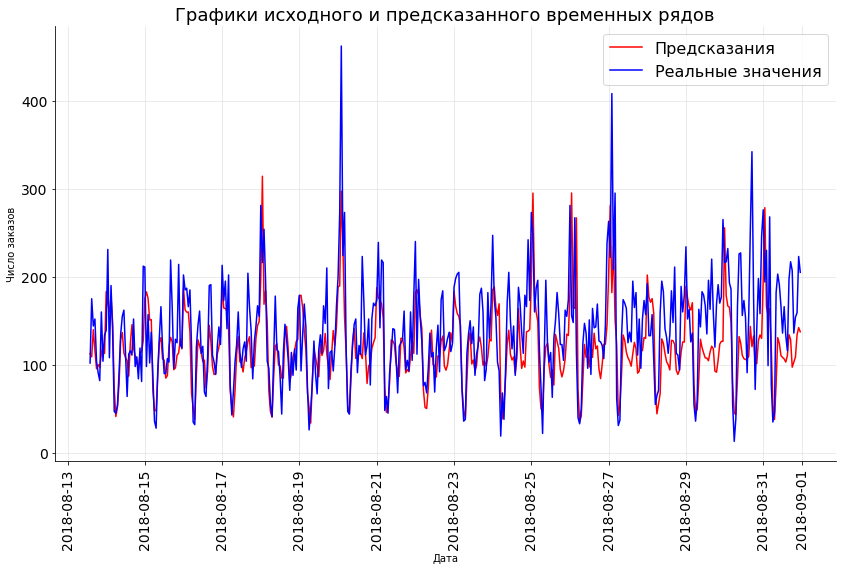

In [ ]:
plt.figure(figsize=(14,8))
sns.lineplot(data=pred_test ['num_orders'], label='Предсказания', color='red')
sns.lineplot(data=target_test.to_frame()['num_orders'], label='Реальные значения', color='blue')
plt.legend(fontsize=16)
plt.ylabel('Число заказов')
plt.xlabel('Дата')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title('Графики исходного и предсказанного временных рядов', fontsize=18)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(alpha=0.3)
plt.show()

**Вывод**

модель, которая была обучена на данных с марта по август 2018 года. Согласно предоставленным данным, среднее количество заказов в час составляет 84, виден рост количества заказов . В процессе обучения модели выделял следующие признаки: месяц заказа, день, день недели, час суток, количество заказов за предыдущий час и скользящее среднее . Всего было обучено 4 типа моделей регрессии с указанными признаками. При кросс-валидации лучшей моделью оказался 'случайный лес'. 

Мы добились результата RMSE меньше 48, на тестировании модель 47,2

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48